<a href="https://colab.research.google.com/github/bkim9/Resume/blob/main/21_7_Sequence_Aware_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# short term behaviors
# Convolutional Sequece Embedding Recommendation model

In [ ]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 3.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
import random
import mxnet as mx
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

In [ ]:
class Caser(nn.Block):
    def __init__(self, num_factors, num_users, num_items, L=5, d=16,
                 d_prime=4, drop_ratio=0.05, **kwargs):
        super(Caser, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.d_prime, self.d = d_prime, d
        # Vertical convolution layer
        self.conv_v = nn.Conv2D(d_prime, (L, 1), in_channels=1)
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        self.conv_h, self.max_pool = nn.Sequential(), nn.Sequential()
        for i in h:
            self.conv_h.add(nn.Conv2D(d, (i, num_factors), in_channels=1))
            self.max_pool.add(nn.MaxPool1D(L - i + 1))
        # Fully connected layer
        self.fc1_dim_v, self.fc1_dim_h = d_prime * num_factors, d * len(h)
        self.fc = nn.Dense(in_units=d_prime * num_factors + d * L,
                           activation='relu', units=num_factors)
        self.Q_prime = nn.Embedding(num_items, num_factors * 2)
        self.b = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, user_id, seq, item_id):
        item_embs = np.expand_dims(self.Q(seq), 1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = np.squeeze(npx.relu(conv(item_embs)), axis=3)
                t = maxp(conv_out)
                pool_out = np.squeeze(t, axis=2)
                out_hs.append(pool_out)
            out_h = np.concatenate(out_hs, axis=1)
        out = np.concatenate([out_v, out_h], axis=1)
        z = self.fc(self.dropout(out))
        x = np.concatenate([z, user_emb], axis=1)
        q_prime_i = np.squeeze(self.Q_prime(item_id))
        b = np.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1) + b
        return res

In [ ]:
class Caser(nn.Block):
    def __init__(self, num_factors, num_users, num_items, L=5, d=16,
                 d_prime=4, drop_ratio=0.05, **kwargs):
        super(Caser, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.d_prime, self.d = d_prime, d
        # Vertical convolution layer
        self.conv_v = nn.Conv2D(d_prime, (L, 1), in_channels=1)
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        self.conv_h, self.max_pool = nn.Sequential(), nn.Sequential()
        for i in h:
            self.conv_h.add(nn.Conv2D(d, (i, num_factors), in_channels=1))
            self.max_pool.add(nn.MaxPool1D(L - i + 1))
        # Fully connected layer
        self.fc1_dim_v, self.fc1_dim_h = d_prime * num_factors, d * len(h)
        self.fc = nn.Dense(in_units=d_prime * num_factors + d * L,
                           activation='relu', units=num_factors)
        self.Q_prime = nn.Embedding(num_items, num_factors * 2)
        self.b = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, user_id, seq, item_id):
        item_embs = np.expand_dims(self.Q(seq), 1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = np.squeeze(npx.relu(conv(item_embs)), axis=3)
                t = maxp(conv_out)
                pool_out = np.squeeze(t, axis=2)
                out_hs.append(pool_out)
            out_h = np.concatenate(out_hs, axis=1)
        out = np.concatenate([out_v, out_h], axis=1)
        z = self.fc(self.dropout(out))
        x = np.concatenate([z, user_emb], axis=1)
        q_prime_i = np.squeeze(self.Q_prime(item_id))
        b = np.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1) + b
        return res

In [ ]:
class SeqDataset(gluon.data.Dataset):
    def __init__(self, user_ids, item_ids, L, num_users, num_items,
                 candidates):
        user_ids, item_ids = np.array(user_ids), np.array(item_ids)
        sort_idx = np.array(sorted(range(len(user_ids)),
                                   key=lambda k: user_ids[k]))
        u_ids, i_ids = user_ids[sort_idx], item_ids[sort_idx]
        temp, u_ids, self.cand = {}, u_ids.asnumpy(), candidates
        self.all_items = set([i for i in range(num_items)])
        [temp.setdefault(u_ids[i], []).append(i) for i, _ in enumerate(u_ids)]
        temp = sorted(temp.items(), key=lambda x: x[0])
        u_ids = np.array([i[0] for i in temp])
        idx = np.array([i[1][0] for i in temp])
        self.ns = ns = int(sum([c - L if c >= L + 1 else 1 for c
                                in np.array([len(i[1]) for i in temp])]))
        self.seq_items = np.zeros((ns, L))
        self.seq_users = np.zeros(ns, dtype='int32')
        self.seq_tgt = np.zeros((ns, 1))
        self.test_seq = np.zeros((num_users, L))
        test_users, _uid = np.empty(num_users), None
        for i, (uid, i_seq) in enumerate(self._seq(u_ids, i_ids, idx, L + 1)):
            if uid != _uid:
                self.test_seq[uid][:] = i_seq[-L:]
                test_users[uid], _uid = uid, uid
            self.seq_tgt[i][:] = i_seq[-1:]
            self.seq_items[i][:], self.seq_users[i] = i_seq[:L], uid

    def _win(self, tensor, window_size, step_size=1):
        if len(tensor) - window_size >= 0:
            for i in range(len(tensor), 0, - step_size):
                if i - window_size >= 0:
                    yield tensor[i - window_size:i]
                else:
                    break
        else:
            yield tensor

    def _seq(self, u_ids, i_ids, idx, max_len):
        for i in range(len(idx)):
            stop_idx = None if i >= len(idx) - 1 else int(idx[i + 1])
            for s in self._win(i_ids[int(idx[i]):stop_idx], max_len):
                yield (int(u_ids[i]), s)

    def __len__(self):
        return self.ns

    def __getitem__(self, idx):
        neg = list(self.all_items - set(self.cand[int(self.seq_users[idx])]))
        i = random.randint(0, len(neg) - 1)
        return (self.seq_users[idx], self.seq_items[idx], self.seq_tgt[idx],
                neg[i])

In [ ]:
TARGET_NUM, L, batch_size = 1, 5, 4096
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_seq_data = SeqDataset(users_train, items_train, L, num_users,
                            num_items, candidates)
train_iter = gluon.data.DataLoader(train_seq_data, batch_size, True,
                                   last_batch="rollover",
                                   num_workers=d2l.get_dataloader_workers())
test_seq_iter = train_seq_data.test_seq
train_seq_data[0]

(array(0, dtype=int32),
 array([241., 170., 110., 255.,   4.]),
 array([101.]),
 1222)

train loss 1.510, test hit rate 0.405, test AUC 0.760
8.0 examples/sec on [gpu(0)]


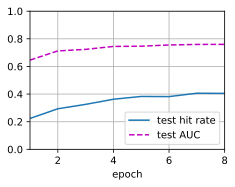

In [ ]:
devices = d2l.try_all_gpus()
net = Caser(10, num_users, num_items, L)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.04, 8, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})

# Running takes > 1h (pending fix from MXNet)
d2l.train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter, num_users, num_items, num_epochs, devices, d2l.evaluate_ranking, candidates, eval_step=1)